# Importing Libraries
In this section, we import the essential Python libraries needed for data analysis, visualization, and machine learning:
- **NumPy & Pandas**: For numerical operations and data manipulation.
- **Matplotlib & Seaborn**: For data visualization.
- **Warnings**: To suppress unnecessary warning messages for cleaner outputs.
- **scikit-learn (StratifiedKFold, metrics, models)**: For model evaluation, splitting data, and building machine learning models (Random Forest, Logistic Regression).
- **XGBoost & LightGBM**: Gradient boosting frameworks widely used for high-performance classification tasks.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
import lightgbm as lgb
import seaborn as sns

# Load Dataset
We load the training and test datasets from the specified file paths.  
- **train**: Used to train and validate the model (contains both features and target labels).  
- **test**: Used for final predictions (usually without target labels).  


In [2]:
train = pd.read_csv("/kaggle/input/rainfall-dataset/train.csv")
test = pd.read_csv("/kaggle/input/rainfall-dataset/test.csv")

# Explore Dataset Structure
We use `train.info()` to check the structure of the training dataset.  
This shows:  
- Number of rows and columns  
- Column names and data types (int, float, object, etc.)  
- Non-null counts (to detect missing values)  
This helps us understand the data quality and preprocessing requirements.  


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.6 KB


# Correlation Matrix Heatmap
We calculate the correlation matrix (`train.corr()`) to analyze relationships between numerical features.  
- Positive values (closer to +1) indicate strong positive correlation.  
- Negative values (closer to -1) indicate strong negative correlation.  
- Values near 0 suggest weak or no correlation.  

The heatmap helps us:  
- Detect multicollinearity (features highly correlated with each other).  
- Identify features that may have stronger relationships with the target variable.  


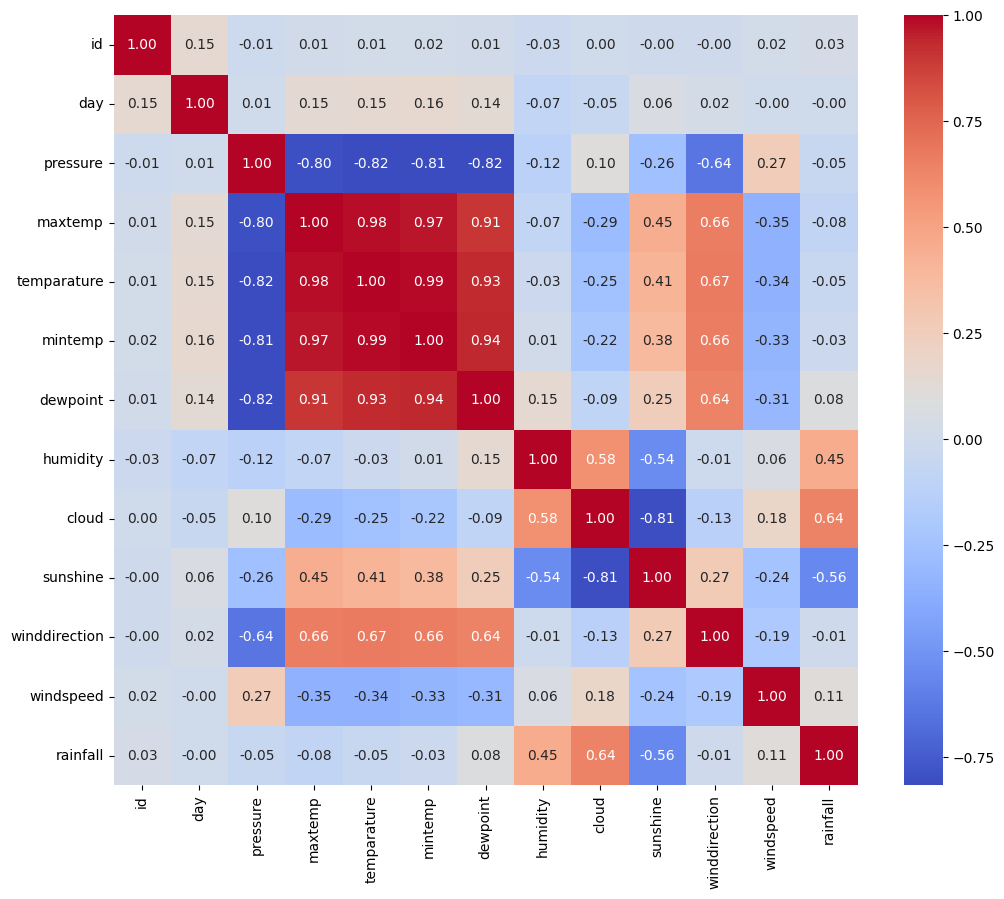

In [4]:
corr_matrix = train.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

# Preparing Training and Test Data
We separate the target variable and drop unnecessary columns:
- **Target (`y`)** → `rainfall` (the value we want to predict).  
- **Dropped columns**:
  - `id` → only an identifier, not useful for prediction.  
  - `day` → date/time-related column, not directly predictive in this form.  
  - `rainfall` (in train only) → target variable, must be excluded from features.  
  - `mintemp`, `maxtemp`, `temparature`, `winddirection` → removed either due to redundancy, correlation, or irrelevance.  

The resulting `train_df` and `test_df` contain only the features we will use for model training.


In [5]:
y = train["rainfall"]
train_df = train.drop(columns=["id","day","rainfall","mintemp","maxtemp","temparature","winddirection"])
test_df  = test.drop(columns=["id","day","mintemp","maxtemp","temparature", "winddirection"])

# Setting Random Seed
To ensure reproducibility of results, we define a random seed (`RND = 42`).  
This guarantees that operations involving randomness (such as data splits, model initialization, or shuffling) will produce the same results every time the code is executed.


In [6]:
RND = 42

# Cross-Validation with Out-of-Fold Predictions
We define the function `get_oof_preds()` to evaluate models using Stratified K-Fold cross-validation:  

- **StratifiedKFold** ensures each fold has the same proportion of classes as the whole dataset (important for imbalanced classification).  
- For each fold:
  - Split data into training (`X_tr, y_tr`) and validation (`X_val, y_val`).  
  - Train the model on the training fold.  
  - Generate predictions for the validation fold and store them in `oof` (out-of-fold predictions).  
  - Predict probabilities on the test set and average across folds.  
  - Calculate and print the ROC AUC score for each fold.  
- The function returns:  
  - `oof`: out-of-fold predictions for the training data.  
  - `test_preds`: averaged predictions for the test set.  

This allows robust model evaluation and provides predictions for both train and test sets without data leakage.


In [7]:
def get_oof_preds(model, X, y, X_test, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RND)
    oof = np.zeros(len(X))
    test_preds = np.zeros(len(X_test))
    fold = 0
    for train_idx, val_idx in skf.split(X, y):
        fold += 1
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_tr, y_tr)
        oof[val_idx] = model.predict_proba(X_val)[:,1]
        test_preds += model.predict_proba(X_test)[:,1] / n_splits
        auc_fold = roc_auc_score(y_val, oof[val_idx][val_idx]) if False else roc_auc_score(y_val, model.predict_proba(X_val)[:,1])
        print(f"  fold {fold} AUC: {roc_auc_score(y_val, model.predict_proba(X_val)[:,1]):.4f}")
    return oof, test_preds

# Handling Class Imbalance
We calculate the ratio of classes to address potential imbalance in the dataset:  

- `count_ones`: number of positive samples (rainfall = 1).  
- `count_zeros`: number of negative samples (rainfall = 0).  
- `scale_pos_weight`: ratio of negative to positive samples, used in models like **XGBoost** or **LightGBM** to give more weight to the minority class.  

This helps the model learn more effectively when one class is much less frequent than the other.


In [8]:
count_ones = (y==1).sum()
count_zeros = (y==0).sum()
scale_pos_weight = count_zeros / (count_ones + 1e-6)
print(f"Classes -> 1s: {count_ones}, 0s: {count_zeros}, scale_pos_weight={scale_pos_weight:.3f}")

Classes -> 1s: 1650, 0s: 540, scale_pos_weight=0.327


# LightGBM Model Setup


In [9]:
lgb_params = {
    "random_state": RND,
    "n_estimators": 1000,
    "learning_rate": 0.03,
    "num_leaves": 31,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "n_jobs": -1,
    "class_weight": "balanced"
}
lgb_model = lgb.LGBMClassifier(**lgb_params)

# XGB Model Setup

In [10]:
xgb_params = {
    "n_estimators": 800,
    "max_depth": 6,
    "learning_rate": 0.03,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "tree_method": "hist",
    "use_label_encoder": False,
    "random_state": RND,
    "scale_pos_weight": scale_pos_weight,
    "n_jobs": -1
}
xgb_model = xgb.XGBClassifier(**xgb_params)

# Random Forest Model Setup

In [11]:
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=12,
    class_weight="balanced",
    random_state=RND,
    n_jobs=-1
)


## Model Training with Cross-Validation

In this section, we train three different models using 5-fold cross-validation:

- **LightGBM (LGBM)**  
- **XGBoost (XGB)**  
- **Random Forest (RF)**  

We evaluate each model using Out-Of-Fold (OOF) predictions and calculate the **ROC AUC score** on the training set.


In [12]:
print("\nTraining LGBM with CV...")
oof_lgb, test_lgb = get_oof_preds(lgb_model, train_df, y, test_df, n_splits=5)
print("LGBM OOF AUC:", roc_auc_score(y, oof_lgb))

print("\nTraining XGB with CV...")
oof_xgb, test_xgb = get_oof_preds(xgb_model, train_df, y, test_df, n_splits=5)
print("XGB OOF AUC:", roc_auc_score(y, oof_xgb))

print("\nTraining RF with CV...")
oof_rf, test_rf = get_oof_preds(rf_model, train_df, y, test_df, n_splits=5)
print("RF OOF AUC:", roc_auc_score(y, oof_rf))


Training LGBM with CV...
[LightGBM] [Info] Number of positive: 1320, number of negative: 432
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 1752, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
  fold 1 AUC: 0.8994
[LightGBM] [Info] Number of positive: 1320, number of negative: 432
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 782
[LightGBM] [Info] Number of data points in the train set: 1752, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training f

## Creating Meta Features for Stacking

In this step, we combine the Out-Of-Fold (OOF) predictions and test predictions
from the three base models (LGBM, XGB, RF) to create meta-features for stacking:

- `meta_train`: OOF predictions stacked column-wise for training the meta-model  
- `meta_test`: Test predictions stacked column-wise for making final predictions  

We also print the shape of `meta_train` to verify the dimensions.


In [13]:
meta_train = np.vstack([oof_lgb, oof_xgb, oof_rf]).T
meta_test  = np.vstack([test_lgb, test_xgb, test_rf]).T
print("Meta train shape:", meta_train.shape)

Meta train shape: (2190, 3)


## Training the Meta-Model (Stacking)

We use **Logistic Regression** as the meta-model to combine predictions
from the base models (LGBM, XGB, RF):

- `meta_model.fit(meta_train, y)`: Train the meta-model on stacked OOF predictions  
- `meta_oof`: Get the predicted probabilities for the training set  
- `meta_auc`: Calculate the ROC AUC score to evaluate the meta-model's performance  

This gives us the performance of the stacked model using Out-Of-Fold predictions.


In [14]:
meta_model = LogisticRegression(C=1.0, max_iter=2000, class_weight='balanced', random_state=RND)
meta_model.fit(meta_train, y)
meta_oof = meta_model.predict_proba(meta_train)[:,1]
meta_auc = roc_auc_score(y, meta_oof)
print(f"\nMeta (stack) OOF AUC: {meta_auc:.4f}")


Meta (stack) OOF AUC: 0.8778


## Refitting Base Models and Making Final Predictions

In this step, we refit all base models (LGBM, XGB, RF) on the **full training set** 
and generate predictions for the test set:

- Each base model predicts probabilities on `test_df`  
- Predictions are stacked column-wise to create `final_meta_test`  
- The trained meta-model (`meta_model`) then predicts final probabilities 
  on the stacked test predictions, giving `final_test_proba`  

This completes the **stacking workflow** and produces the final ensemble predictions.


In [15]:
print("\nRefitting base models on full train and predicting test...")
lgb_model.fit(train_df, y)
xgb_model.fit(train_df, y)
rf_model.fit(train_df, y)

test_pred_lgb = lgb_model.predict_proba(test_df)[:,1]
test_pred_xgb = xgb_model.predict_proba(test_df)[:,1]
test_pred_rf  = rf_model.predict_proba(test_df)[:,1]

final_meta_test = np.vstack([test_pred_lgb, test_pred_xgb, test_pred_rf]).T
final_test_proba = meta_model.predict_proba(final_meta_test)[:,1]


Refitting base models on full train and predicting test...
[LightGBM] [Info] Number of positive: 1650, number of negative: 540
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 818
[LightGBM] [Info] Number of data points in the train set: 2190, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


## Evaluating Base and Stacked Models

- Print the **ROC AUC scores** for each base model (LGBM, XGB, RF) using OOF predictions  
- Print the **ROC AUC score** for the stacked (meta) model  

We also visualize the **ROC curve** for the stacked model to see how well it
discriminates between classes:

- `fpr`, `tpr`: False Positive Rate and True Positive Rate for the ROC curve  
- Plot shows the ROC curve with the AUC value for the stacked model



OOF AUC scores (base): 0.8593389450056117 0.863925925925926 0.8781464646464646
Stacked (meta) OOF AUC: 0.8778114478114478


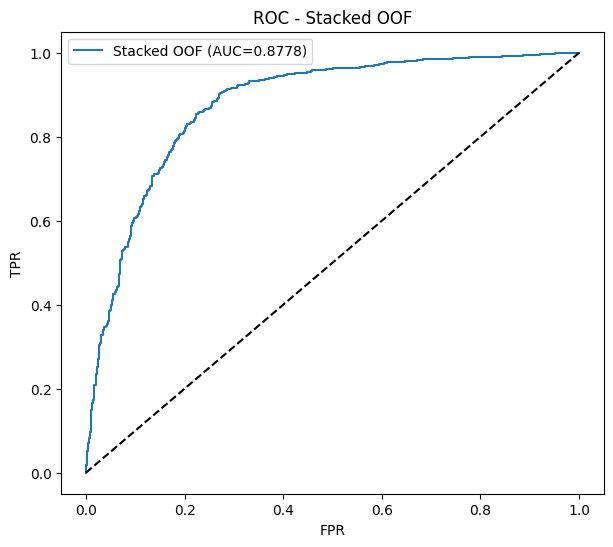

In [16]:
print("\nOOF AUC scores (base):",
      roc_auc_score(y, oof_lgb),
      roc_auc_score(y, oof_xgb),
      roc_auc_score(y, oof_rf))
print("Stacked (meta) OOF AUC:", meta_auc)

# ROC curve for stacked oof
fpr, tpr, _ = roc_curve(y, meta_oof)
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f'Stacked OOF (AUC={meta_auc:.4f})')
plt.plot([0,1],[0,1],"k--")
plt.legend(); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC - Stacked OOF")
plt.show()

## Creating Submission File

- Combine `test` IDs with the **final stacked predictions** (`final_test_proba`)  
- Save the results as `submission.csv` for submission  
- Display the first few rows to verify the file


In [17]:
submission = pd.DataFrame({"id": test["id"], "rainfall": final_test_proba})
submission.to_csv("submission.csv", index=False)
print("submission.csv saved. Final stacked test prob head:\n", submission.head())

submission.csv saved. Final stacked test prob head:
      id  rainfall
0  2190  0.857865
1  2191  0.852423
2  2192  0.624835
3  2193  0.066106
4  2194  0.032648
